<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [34]:
# Import analysis packages
%matplotlib inline
import stan as ps
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as ss
from patsy import dmatrix,Treatment


# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply();

In [2]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Two-way ANOVA as Bayesian model

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for the question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. If scientific research publication is the goal the priors will need to be accepted by a skeptical audience. This should be achievable using prior predictive checks to ascertain if the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then use the posterior for conducting your inferences.

5. Conduct model checks. i.e. Posterior predictive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for the question under investigation

## Study data/description

The following analysis has been conducted on data originally analysed by Maglio & Polman (2014). https://sites.google.com/view/openstatslab/home/factorial-anova

The psychological literature suggests that both the physical distance and psychological factors can influence peoples' perceptions of distance. An example of this is the percieved distance to walk to a location when fed than when in a caloric deficit.

The data analysed below is from Maglio and Polman (2014) whom investigated this general distance perception phenomenon. Specifically investigating, the effect of spatial orientation on percieved distance. This was achieved through the acqusition of 202 participants from the Toronto underground green trainline. Half of the passengers were headed eastbound and the other half westbound. The particpants were then further sub-divded indepently to give their pericieved distance from 4 different locations. For the analysis below two of these stations have been dropped for simplicity of exposition and to demonstrate the most common experimental design in psychology the 2x2 with a Bayesian model equivalent to the 2x2 Between subjects ANOVA using prior specified contrasts in a linear model (Schad, Vasishth, Hohenstein and Kliegl, 2020).

In [45]:
url = 'https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Maglio%20and%20Polman%202014.csv'
df = pd.read_csv(url)

In [46]:
# Reduce the dataset to demonstrate 2x2 for simplicities sake
dfReduced = df[df.station < 3]

In [94]:
dfReduced['station'] = dfReduced['station'].astype('category')
dfReduced['direction'] = dfReduced['direction'].astype('category')

/storage/gold/cinn/misc/software/Ubuntu/20.04/envs/pystan_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/storage/gold/cinn/misc/software/Ubuntu/20.04/envs/pystan_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


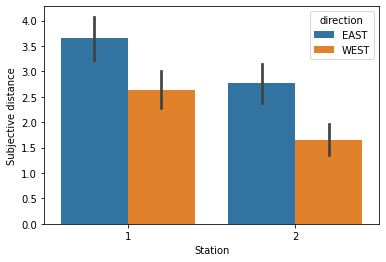

In [128]:
sns.barplot(x = "station", y = "subjective_distance", hue = "direction", data = dfReduced);
plt.xlabel('Station');
plt.ylabel('Subjective distance');

In [174]:
TbTBA = """
data{
int N; // Number of observations
vector[N] y;
int K; // Number of predictors
matrix[N, K] X; // The design matrix

real beta_sigma;
real sigma_mu;
real sigma_sigma;

int<lower= 0, upper = 1> onlyprior; 
}

transformed data{
real SD;
real Mean = mean(y);
SD = sd(y);
}

parameters{
vector[K] beta;
real<lower = 0> sigma;
}

model{
// Priors
beta[1] ~ normal(Mean, 2.5 * SD);
beta[2:K] ~ normal(0, beta_sigma);
sigma ~ normal(sigma_mu, sigma_sigma);

// Likelihood
if(!onlyprior)
y ~ normal(X * beta, sigma);
}

generated quantities{
vector[K - 1] effect_sizes = beta[2:K]/sigma;
// Generate simulated data sets  to run posterior predictive checks.
real yrep[N];
yrep = normal_rng(X * beta, sigma);
}


"""

In [175]:
directionc = np.where(dfReduced['direction'] == 'EAST', -.5, .5)
stationc = np.where(dfReduced['station']== 1, -.5, .5)

In [176]:
dic = {'intercept':   np.repeat(1, len(dfReduced)),
       'directionc': directionc,
       'stationc': stationc,
       'inter': np.asarray(directionc) * np.asarray(stationc)}

X = np.asarray(pd.DataFrame(dic))

In [214]:
# Generate python dictionary 
data = {'N': len(dfReduced),
        'y': dfReduced['subjective_distance'].values,
         'X': X,
         'K': np.shape(X)[1],
        'beta_sigma': 2.,
        'sigma_mu': 0.,
        'sigma_sigma': 1.,
        # Set to one to run prior predictive checks
        'onlyprior': 0}

In [215]:
# Compile stan model into C++ code.
# Warnings for priors
sm = ps.build(TbTBA, data = data)

Building...



Building: found in cache, done.Messages from stanc:


In [216]:
# Sample posteriors for the model
fit = sm.sample(num_chains = 4, num_samples = 2000)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!


In [217]:
# Print summary table for model fit results
az.summary(fit, var_names = ['beta', 'sigma', 'effect_sizes'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.676,0.099,2.497,2.874,0.001,0.001,9888.0,6007.0,1.0
beta[1],-1.062,0.195,-1.424,-0.687,0.002,0.001,9963.0,6207.0,1.0
beta[2],-0.937,0.196,-1.326,-0.591,0.002,0.001,10710.0,6310.0,1.0
beta[3],-0.115,0.391,-0.844,0.606,0.004,0.004,9438.0,5798.0,1.0
sigma,0.998,0.072,0.864,1.129,0.001,0.001,9067.0,5939.0,1.0
effect_sizes[0],-1.070,0.211,-1.470,-0.670,0.002,0.001,10176.0,5930.0,1.0
effect_sizes[1],-0.944,0.208,-1.348,-0.570,0.002,0.001,10774.0,5841.0,1.0
effect_sizes[2],-0.116,0.391,-0.849,0.601,0.004,0.004,9640.0,5852.0,1.0


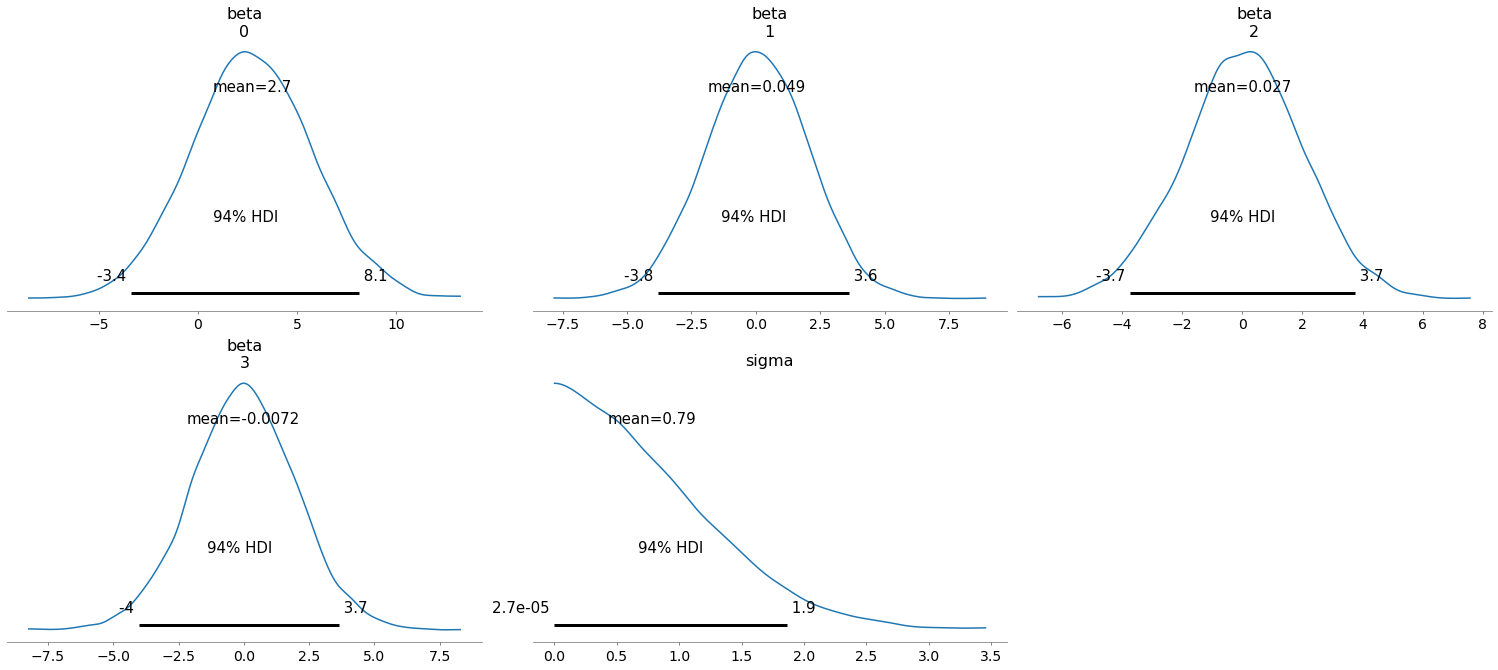

In [212]:
az.plot_posterior(fit, var_names = ['beta', 'sigma']);

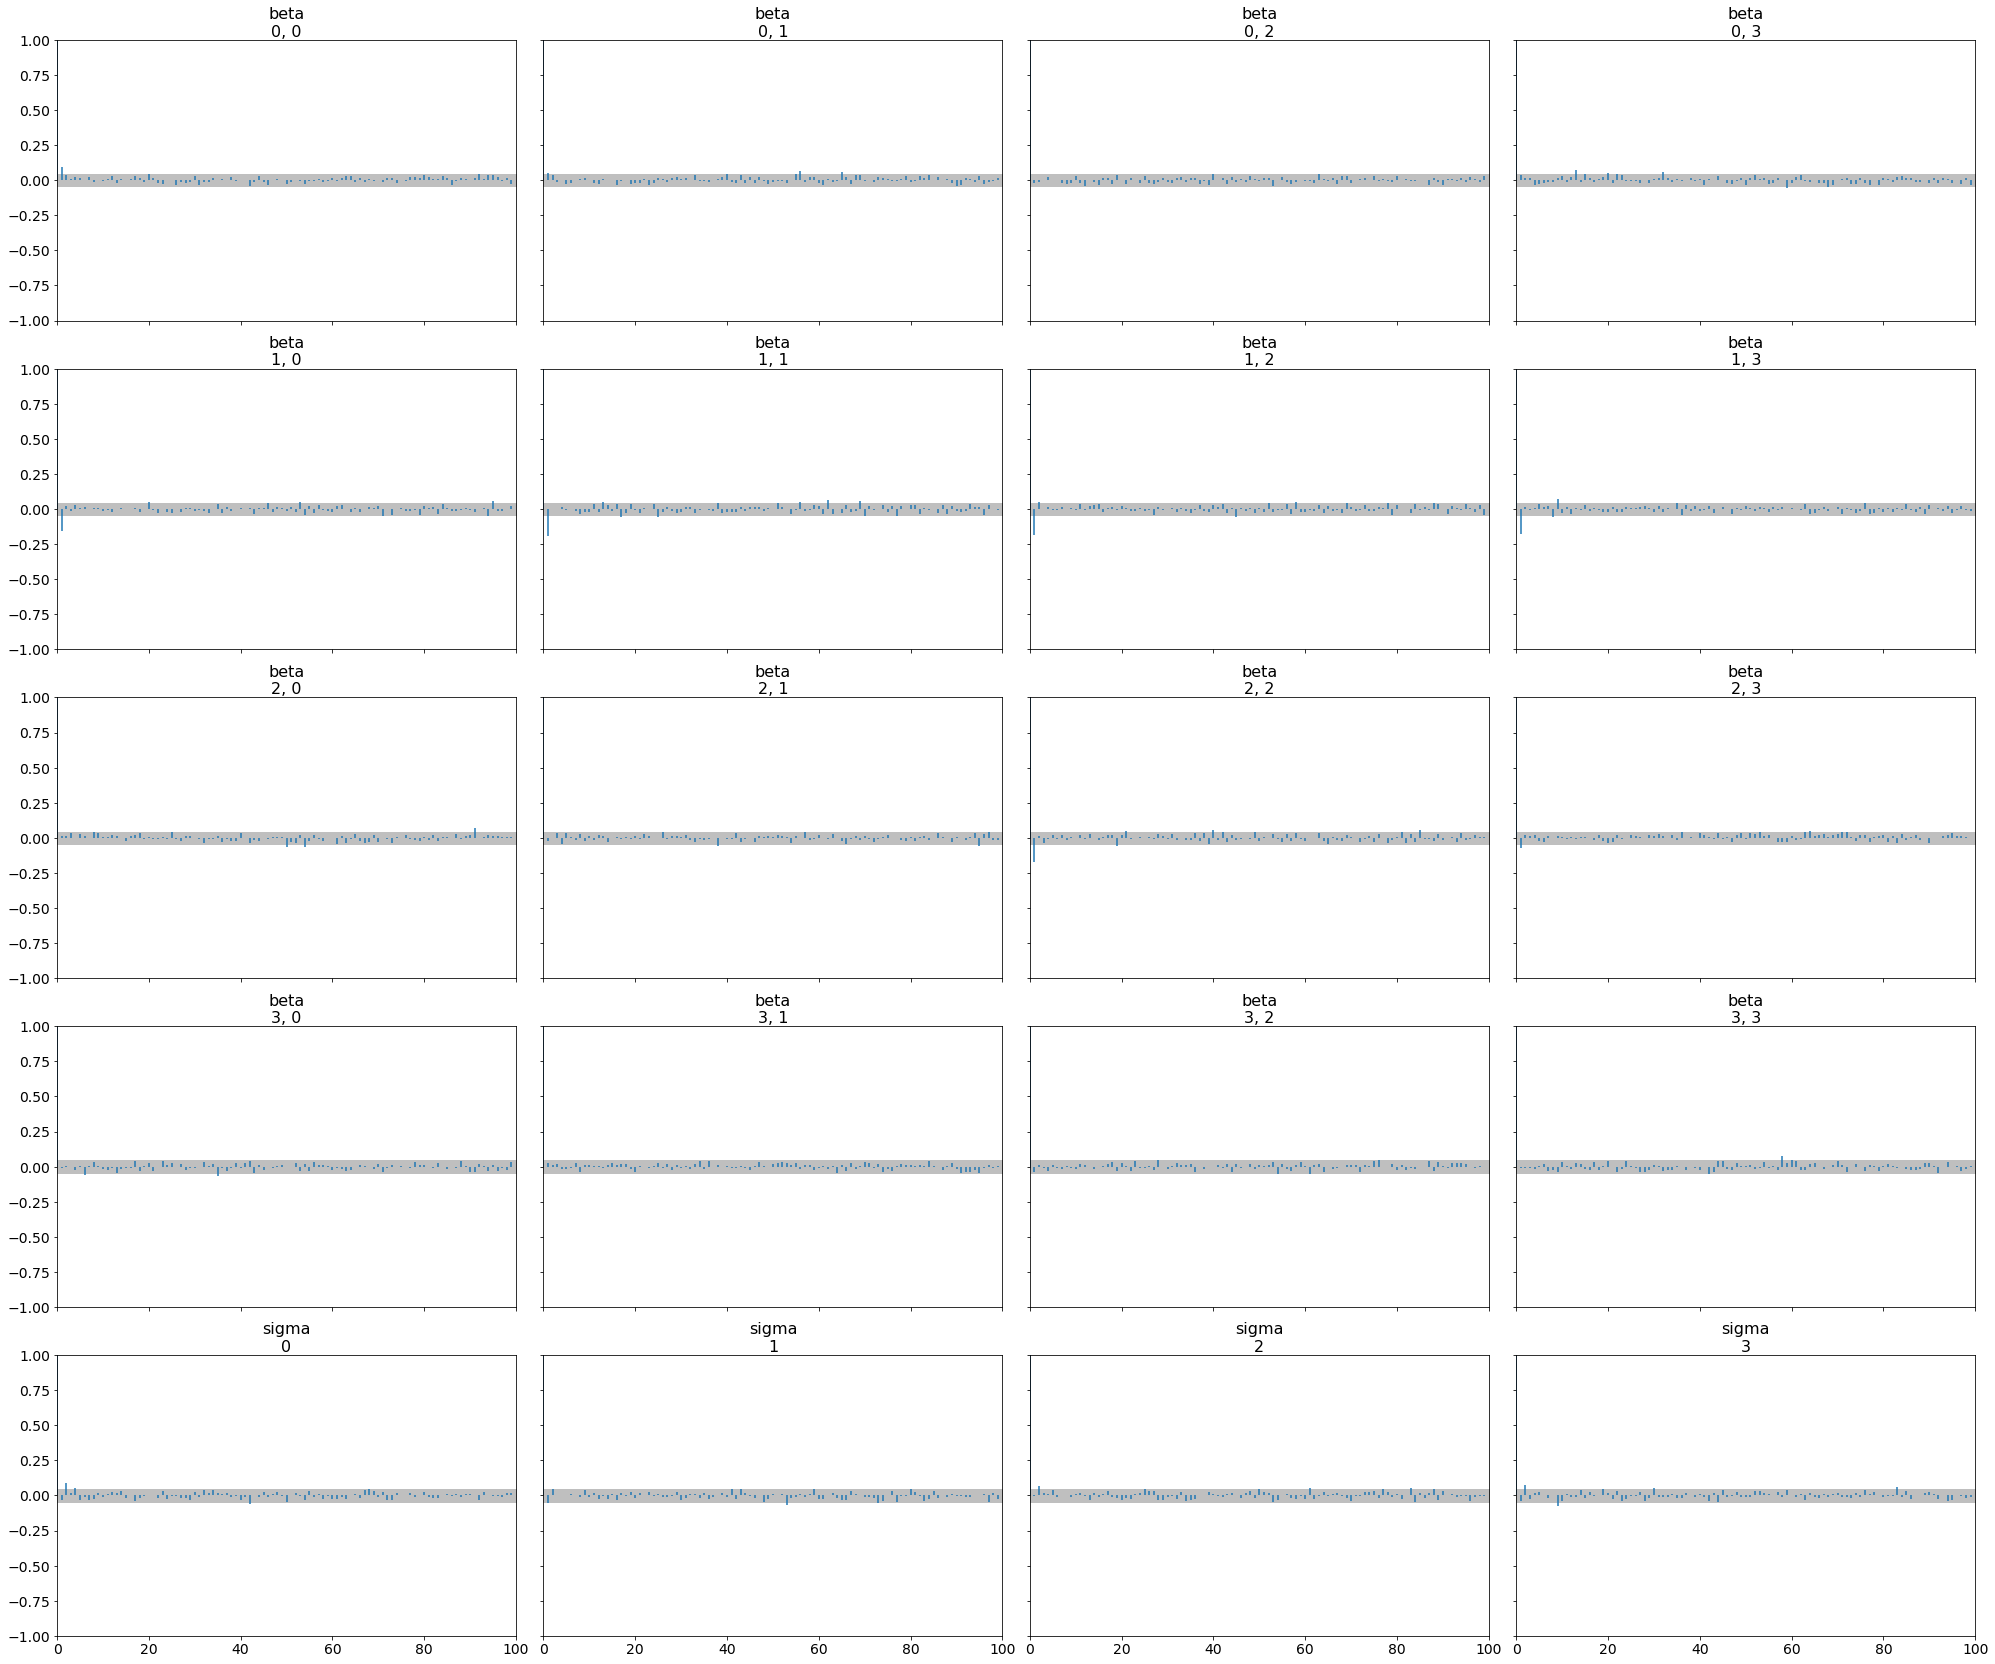

In [210]:
az.plot_autocorr(fit, var_names = ['beta', 'sigma']);

Autocorrelation plots show no pathologies all chains quickly returning to 0

## Posterior predicitve checks

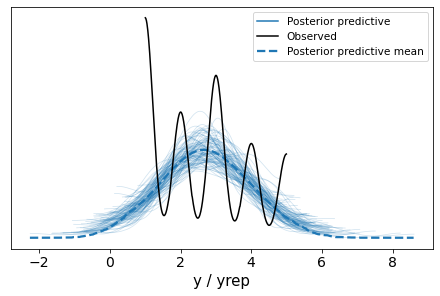

In [218]:
# Convert pystan fit object to Infercne Object for Arviz functions.
idata = az.from_pystan(posterior = fit, posterior_model = sm, posterior_predictive = ['yrep'], observed_data= 'y')

# Plot posterior simulated data sets for prior/posterior predictive check
if data['onlyprior'] == 1:
    az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples= 100, observed = False);
else:
    az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples= 100);

As the posterior predictive checks show above there is a quite dractic misfit of the model. What is happening here. The reason for such a poor fit is the the fact the data anlysed was ordinal. As such the normal likelihood used here and one of the assumptions in classical ANOVA's is inappropriate for such type of data. However the use of such inapproapriate models is common in the psychological sciences (Liddell & Kruscke, 2018). There are arguements in the literature that ANOVA can be robust in analysing ordinal data. The authors of this notebook make no counter arguments around this issue. We only direct readers to the alternative generalised (ordinal) linear models (Liddell & Kruscke, 2018), that by design fit the data better. These types models are demonstrated in their own notebooks.

<font size = "3">As Kruschke (2015) correctly points out there is not standard formula or presentation method for reuslts in journal article like the APA guide for reporting frequentist analysis. It is likely there never will be, because as McElreath (2020) explains, Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2019) argue visualisations maybe even more key. So, all the visualisations above would have to be included with any write up. Anyway, below the write up generally follows the advice of Kruschke (2015) chapter 25. In any application though it comes down to the problem to be described an the audience that needs to be convinced. </p><br/>

<h2>Write up of categorical regression</h2><br/>

Note having fitted the model and observed the ill fit it is likely that the following write would have little utility, given that the data is ordinal and a normal likelihood was inappropriate for this data analysis problem. Of course, throughout the scientific literatue their are countless examples of inappropriate models applied to data, McElreath (2020). Now, bearing that in mind, the following write up is still a useful example for how to write up a 2x2 design analysis using an Bayesian regression equivalent of two-way factorial ANOVA.  

# References

Liddell, T. M., & Kruschke, J. K. (2018). Analyzing ordinal data with metric models: What could possibly go wrong?. Journal of Experimental Social Psychology, 79, 328-348.

Maglio, S. J., & Polman, E. (2014). Spatial orientation shrinks and expands psychological distance. Psychological Science, 25, 1345-1352.

Schad, D. J., Vasishth, S., Hohenstein, S., & Kliegl, R. (2020). How to capitalize on a priori contrasts in linear (mixed) models: A tutorial. Journal of Memory and Language, 110, 104038.